In [1]:
# UPORABNO:
# Povezava: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [2]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

In [3]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=';')
podatki["DateTimeStartCET"] = pd.to_datetime(podatki["DateTimeStartCET"], format="%d.%m.%Y %H:%M")

podatki['Odjem ACT'] = podatki['Odjem ACT'].str.replace(',','.').astype(np.float64)

podatki = podatki.set_index('DateTimeStartCET')
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki

,DateTimeStartUTC,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartCET,,,,,,,,,
2021-11-01 00:00:00,31.10.2021 23:00,0.951,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:15:00,31.10.2021 23:15,0.917,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:30:00,31.10.2021 23:30,0.886,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 00:45:00,31.10.2021 23:45,0.851,3.jun,5.mar,0,0,2021,11,2021-11-01
2021-11-01 01:00:00,1.11.2021 00:00,0.833,mar.45,5.mar,0,0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...,...
2024-02-29 22:45:00,29.02.2024 21:45,1.200,6.avg,7.475,0,0,2024,2,2024-02-29
2024-02-29 23:00:00,29.02.2024 22:00,1.130,jun.65,7.mar,0,0,2024,2,2024-02-29
2024-02-29 23:15:00,29.02.2024 22:15,1.080,6.maj,7.mar,0,0,2024,2,2024-02-29


In [15]:
## Številki opis podatkov:
df = pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))
df

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,0.000005,2.87,1.112501,1.12,0.518191


In [86]:
## Vizualizacija
sns.set(rc={'figure.figsize':(20, 4)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartCET'>

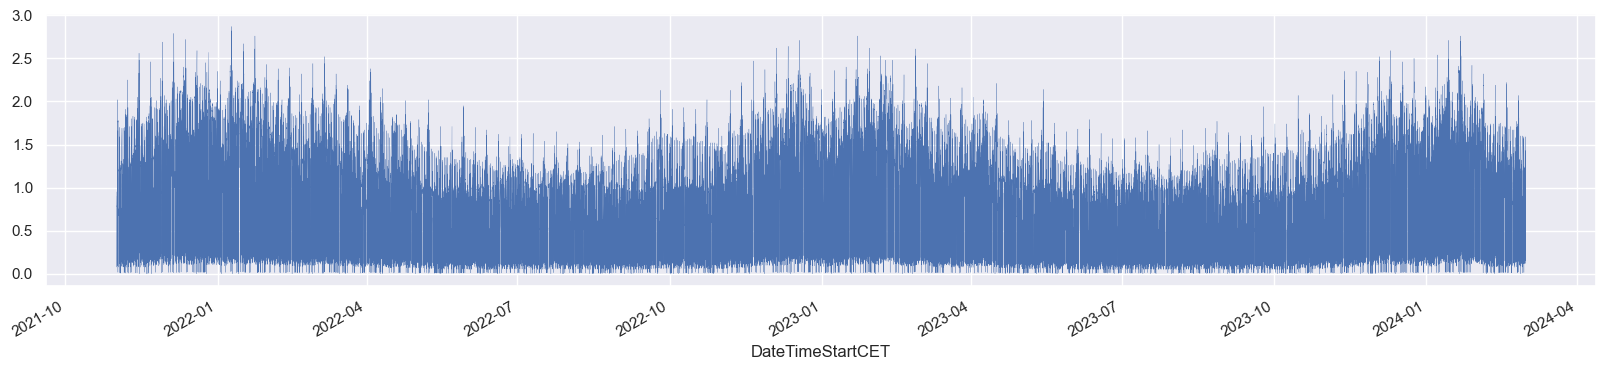

In [87]:
podatki['Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

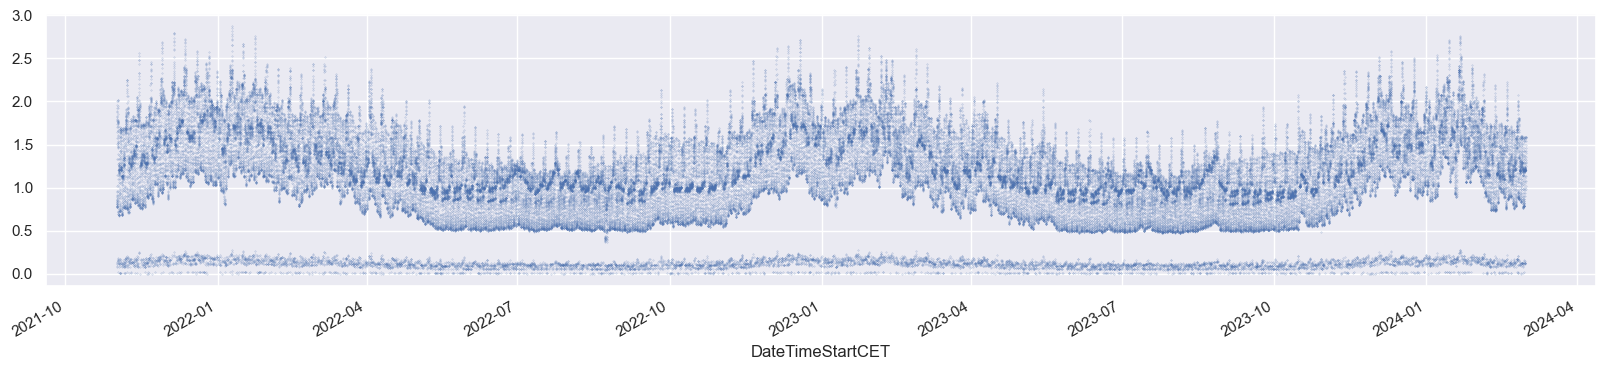

In [88]:
podatki['Odjem ACT'].plot(marker='.', alpha=0.5, linestyle='None', ms=0.5)
# iz tega grafa je malo boljše lažje razbrat stvari

In [49]:
# opazke:
# - poraba je večja v zimskih mesecih
# - poraba se v času božičnih praznikov (konec decembra, začetek januarja) zmanjša
# - tisto kar je blizu nič predstavlja porabo tekom noči

<AxesSubplot: xlabel='DateTimeStartCET'>

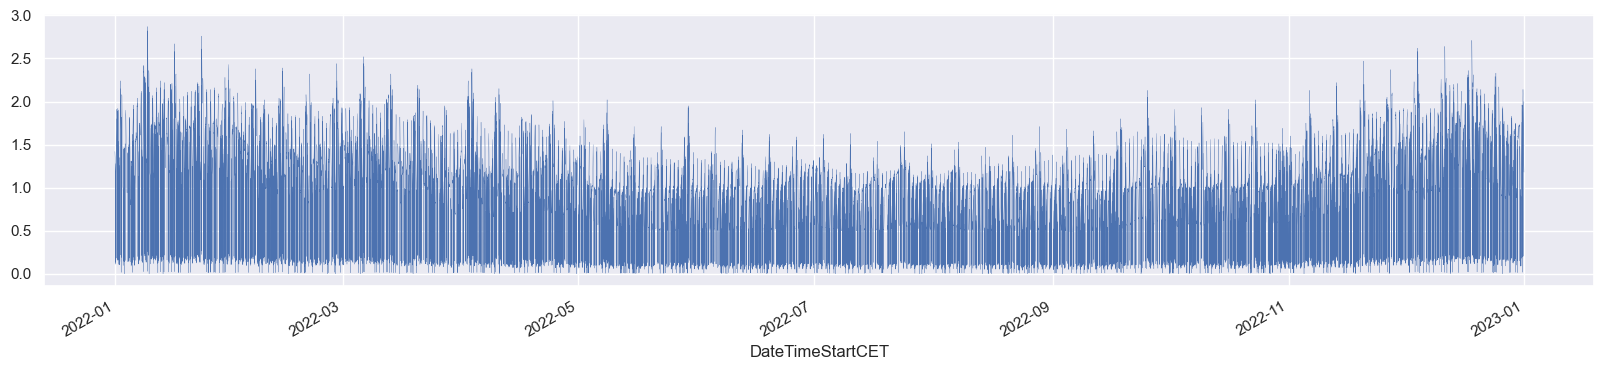

In [89]:
## odjem leta 2022:
podatki.loc['2022', 'Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

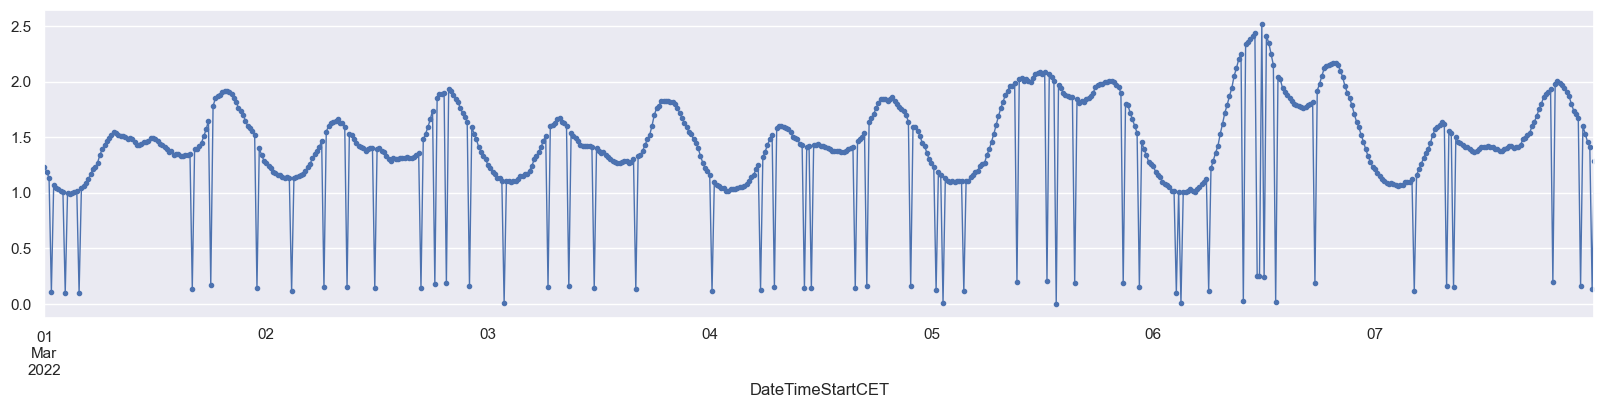

In [90]:
# odjem za en teden
podatki.loc['2022-03-01':'2022-03-07', 'Odjem ACT'].plot(marker='o', linestyle='-', linewidth=1, ms=3)

In [ ]:
## NAREDIMO ČASOVNO VRSTO STACIONARNO

# očitno je, da vrsta NI stacionarna

<AxesSubplot: xlabel='DateTimeStartCET'>

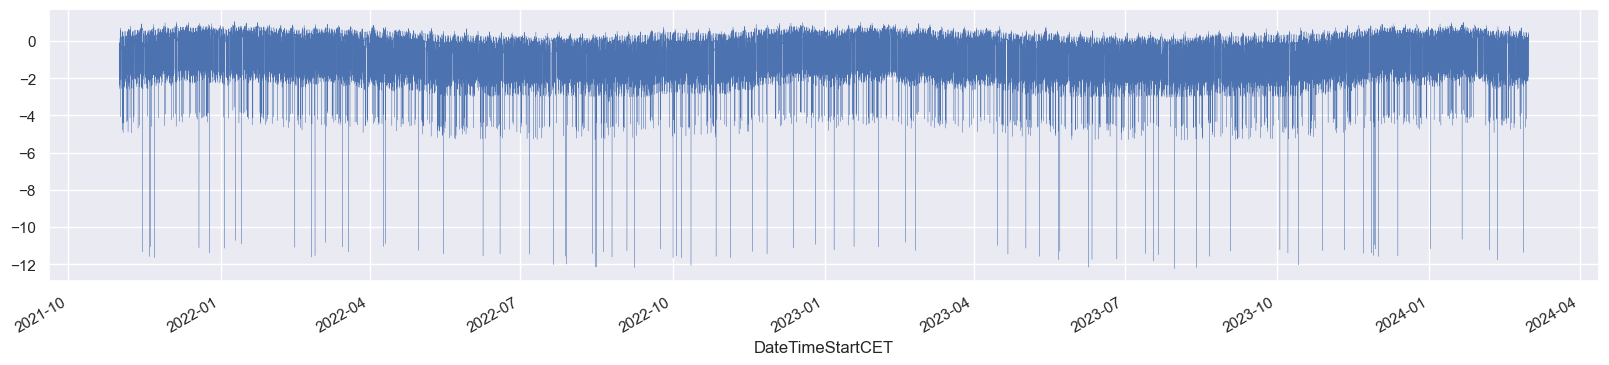

In [91]:
# Podatki so volatilni, zato najprej naredimo logaritemsko transformacijo (log(D_t)). Tako se vse malo bolj stabilizira 
podatki['Logaritem'] = np.log(podatki['Odjem ACT'])
podatki['Logaritem'].plot(linewidth=0.2)

Text(0.5, 1.0, 'Logaritem časovne vrste odjema, 2023')

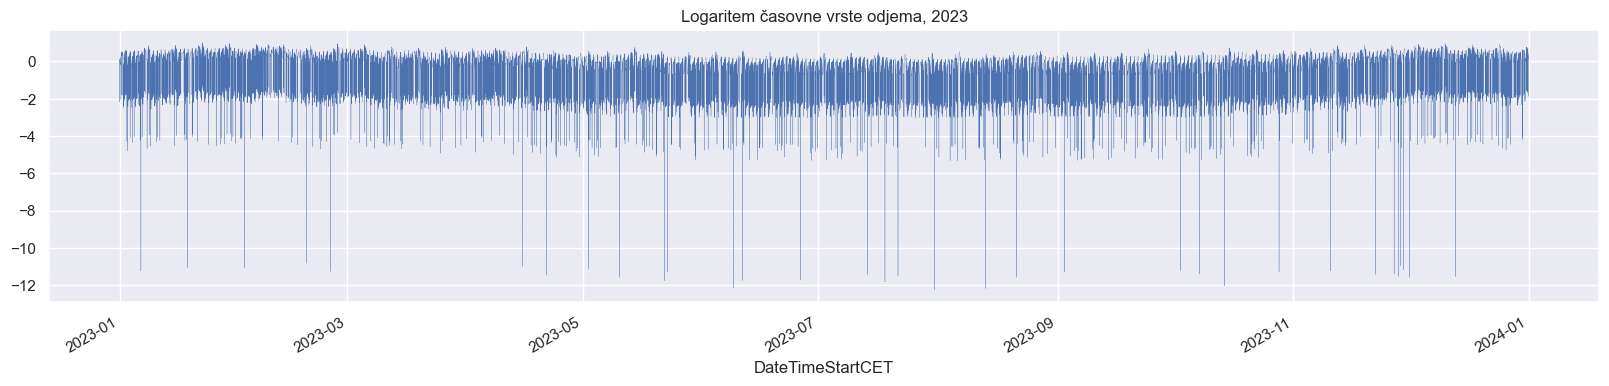

In [92]:
# zaradi velike količine podatkov, se bom osredotočala na leto 2023
podatki.loc['2023', 'Logaritem'].plot(linewidth=0.2) 
plt.title('Logaritem časovne vrste odjema, 2023')

Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, 2023')

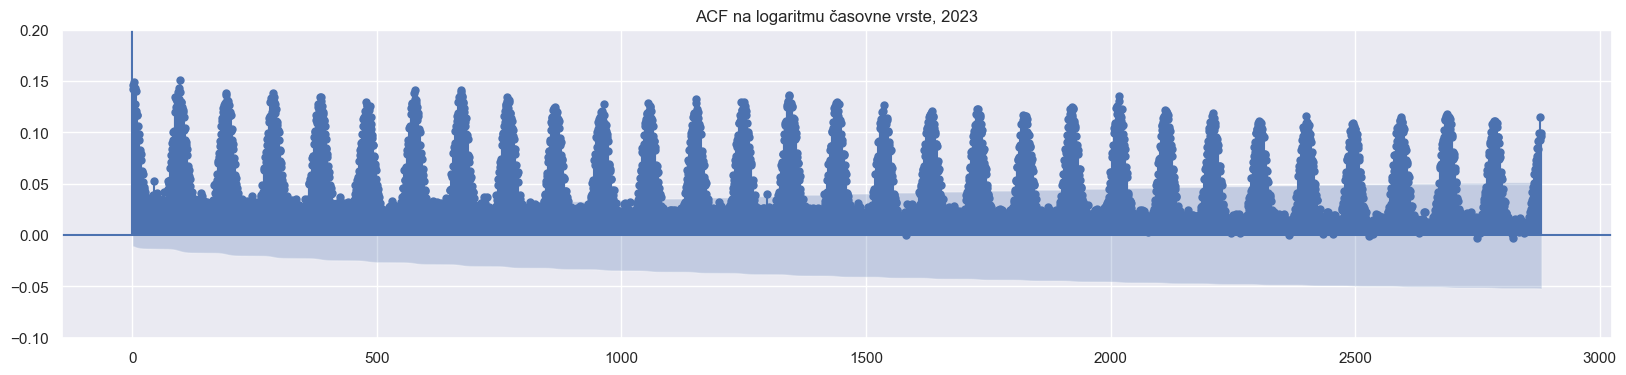

In [93]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=2880)
plt.ylim(-0.1,0.2)
plt.title('ACF na logaritmu časovne vrste, 2023')

# za lag sem vzela 2880, to je ravno 30 dni (96 podatkov na dan * 30 dni)

In [94]:
# Iz ACF vidimo:
# - stacionarnosti NI
# - smiselno sezonsko komponento -> vse se ponavlja se na 1 dan (96 podatkov)

# da doseženo stacionarno poskusimo DIFERENCIRATI

Text(0.5, 1.0, 'Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

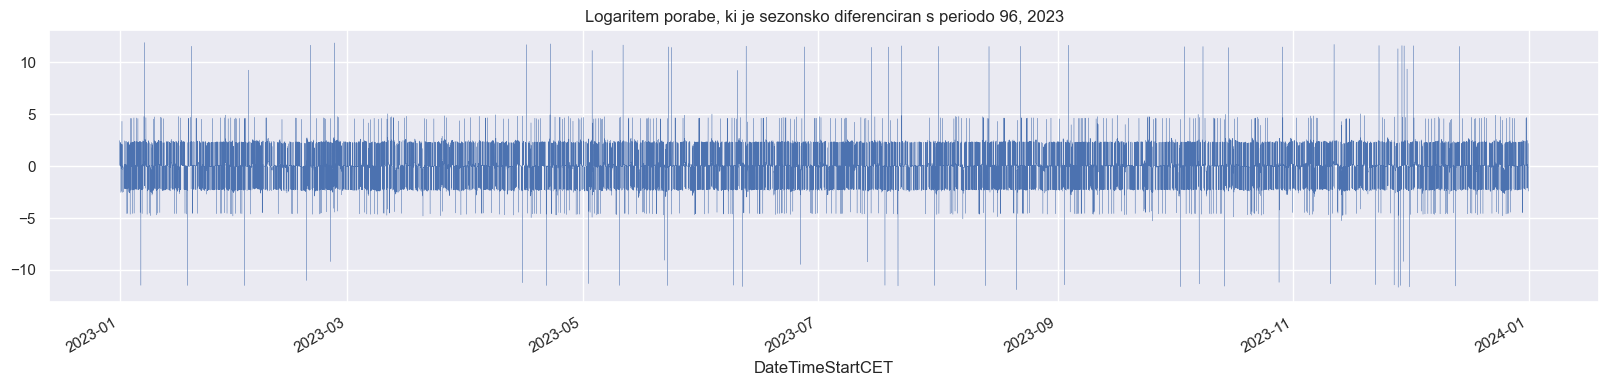

In [95]:
ts_diff = podatki['Logaritem'].diff(periods = 96)
ts_diff['2023'].plot(linewidth=0.2) 
plt.title('Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

In [ ]:
# opazimo, da je časovna vrsta kar precej bolj stacionarna. Preverimo še ACF

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, 2023')

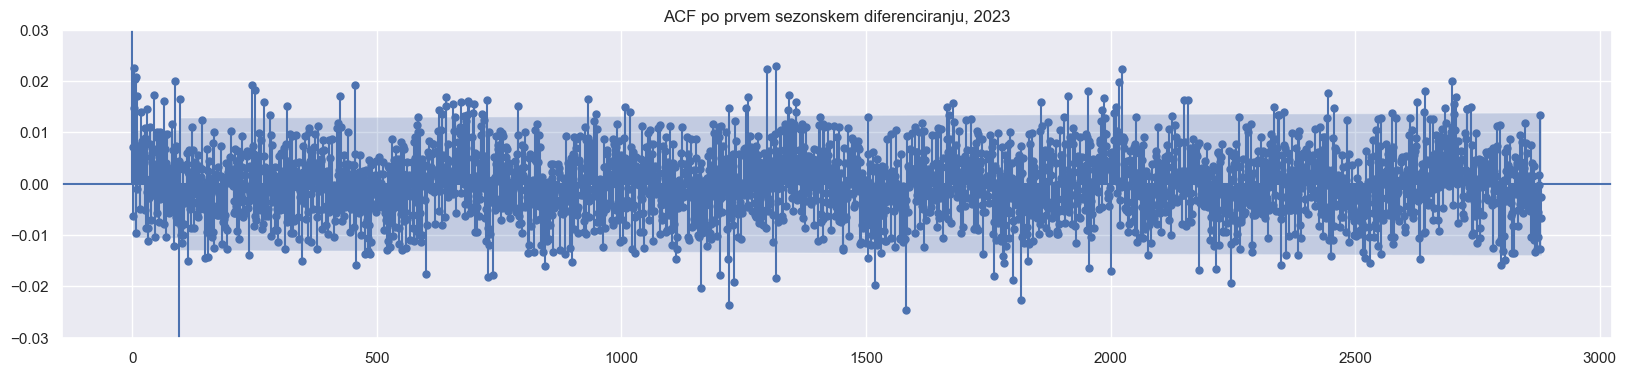

In [96]:
tsaplots.plot_acf(ts_diff['2023'], lags=2880)
plt.ylim(-0.03,0.03)
plt.title('ACF po prvem sezonskem diferenciranju, 2023')

In [ ]:
# zgleda stacionarno, ampak diferencirajmo še enkrat

Text(0.5, 1.0, 'Po drugem diferenciranju, 2023')

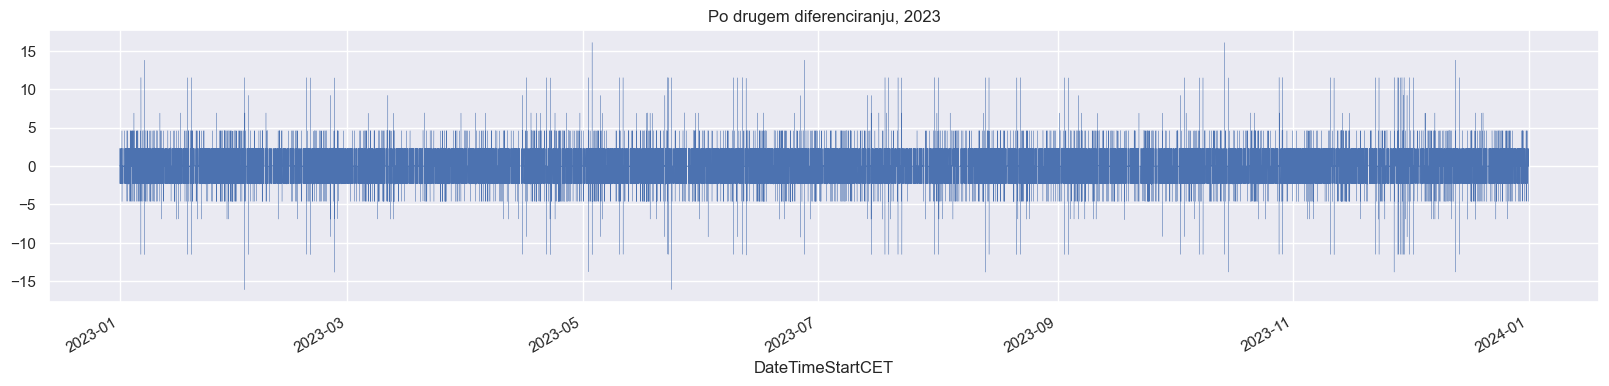

In [97]:
ts_diff2 = ts_diff.diff()
ts_diff2['2023'].plot(linewidth=0.2) 
plt.title('Po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, 2023')

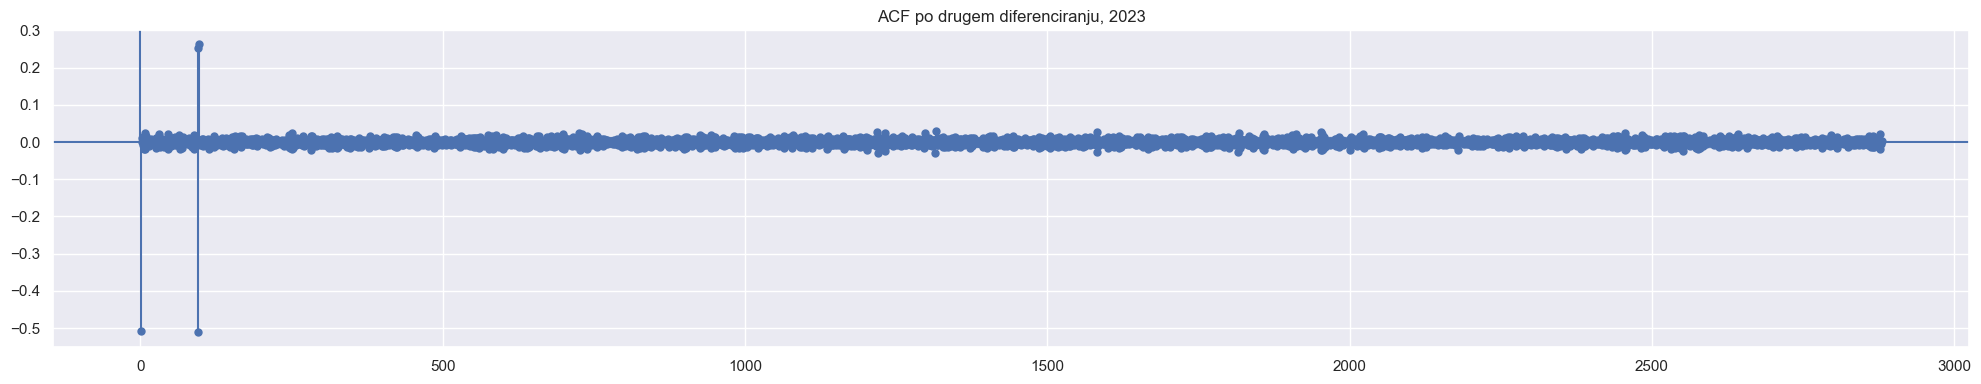

In [106]:
tsaplots.plot_acf(ts_diff2['2023'], lags=2880)
plt.ylim(-0.55,0.3)
plt.tight_layout()
plt.title('ACF po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, 2023')

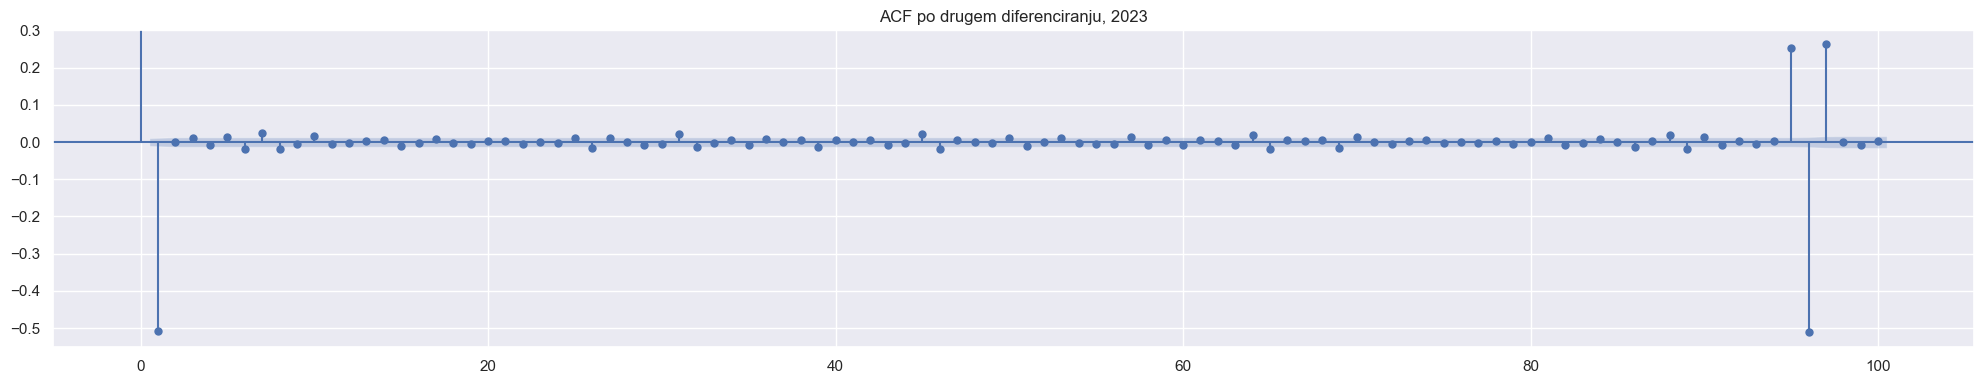

In [114]:
tsaplots.plot_acf(ts_diff2['2023'], lags=100)
plt.ylim(-0.55,0.3)
plt.tight_layout()
plt.title('ACF po drugem diferenciranju, zožen lag, 2023')

In [111]:
# sedaj zgleda še bolj stacionarno, torej je primerna za model ARMA

# iz ACF se visoko avtokorelacijo opazi pri: 1, 95, 96, 97

# RABIM FORMALNE TESTE?

Text(0.5, 1.0, 'PACF po drugem diferenciranju, 2023')

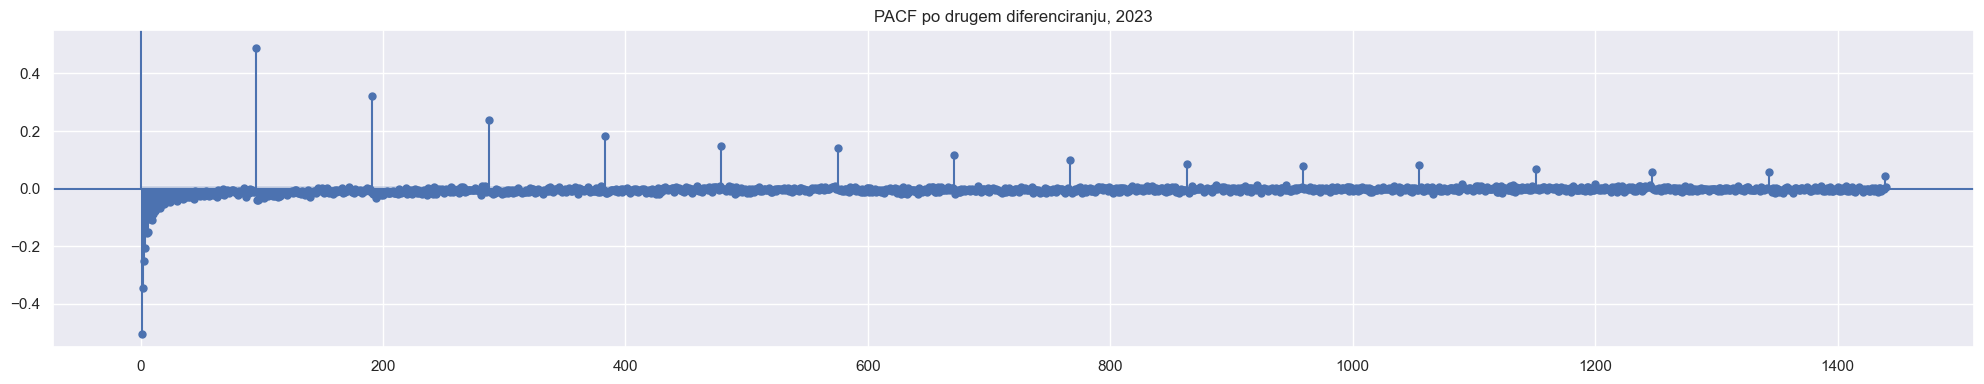

In [122]:
# zaradi izbire modelov si narišemo še PACF

tsaplots.plot_pacf(ts_diff2['2023'].values.squeeze(), lags=1440, method="ywm")
plt.ylim(-0.55,0.55)
plt.tight_layout()
plt.title('PACF po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'PACF po drugem diferenciranju, zožen lag, 2023')

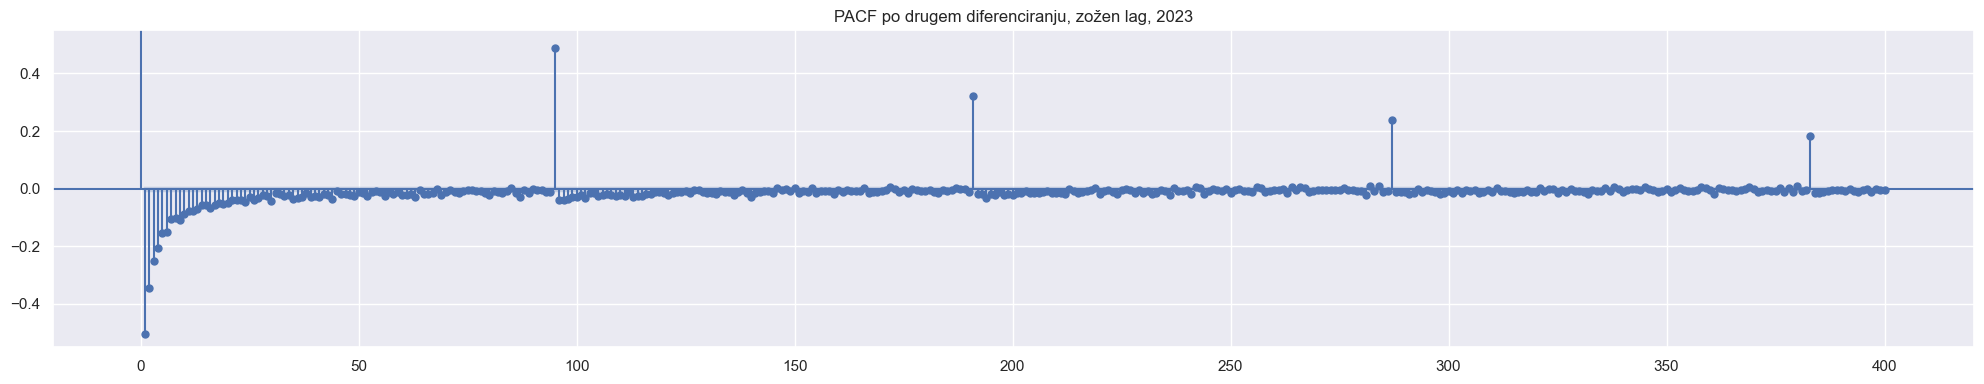

In [127]:
tsaplots.plot_pacf(ts_diff2['2023'].values.squeeze(), lags=400, method="ywm")
plt.ylim(-0.55,0.55)
plt.tight_layout()
plt.title('PACF po drugem diferenciranju, zožen lag, 2023')

In [ ]:
# visoka korelacije je pri: 1, 2, 95, 191, se ponovi na 96

# PACF -> AR(p)
# ACF -> MA(q)


# ACF in PACF povesta katere log bi bilo potrebno vključiti
# Zagotovo bomo vključili prvih nekaj meritev/ur, ker imajo večji vpliv
# Koliko dodatnih log-ov bomo še vključili, pa se bomo odločili s pomočjo kriterija AIC

In [ ]:
## MODELI
